In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
stats = pd.read_csv("features.csv")
del stats["Unnamed: 0"]
data = stats[stats['TOTAL_seasons'] >= 3]
player_list = data['Player'].unique()
from sklearn.model_selection import train_test_split

# Split players into training and test sets
train_players_list, test_players_list = train_test_split(player_list, random_state = 42)


In [3]:
def train_or_test(player):
    if player in train_players_list:
        return 'train'
    else:
        return 'test'

data['train_test'] = data['Player'].apply(train_or_test)

In [4]:
train = data[data['train_test'] == 'train']
test = data[data['train_test'] == 'test']

In [5]:
def logit(p):
    if p > 0.95:
        p = 0.95
    if p < 0.05:
        p = 0.05
    return np.log(p/(1-p))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [6]:
features = ['minutes_proportion', 'two_point_percentage', 'two_point_attempts', 'three_point_percentage',
              'three_point_attempts', 'free_throw_percentage','free_throw_attempts', 'defensive_rebounds',
              'offensive_rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'personal_fouls']

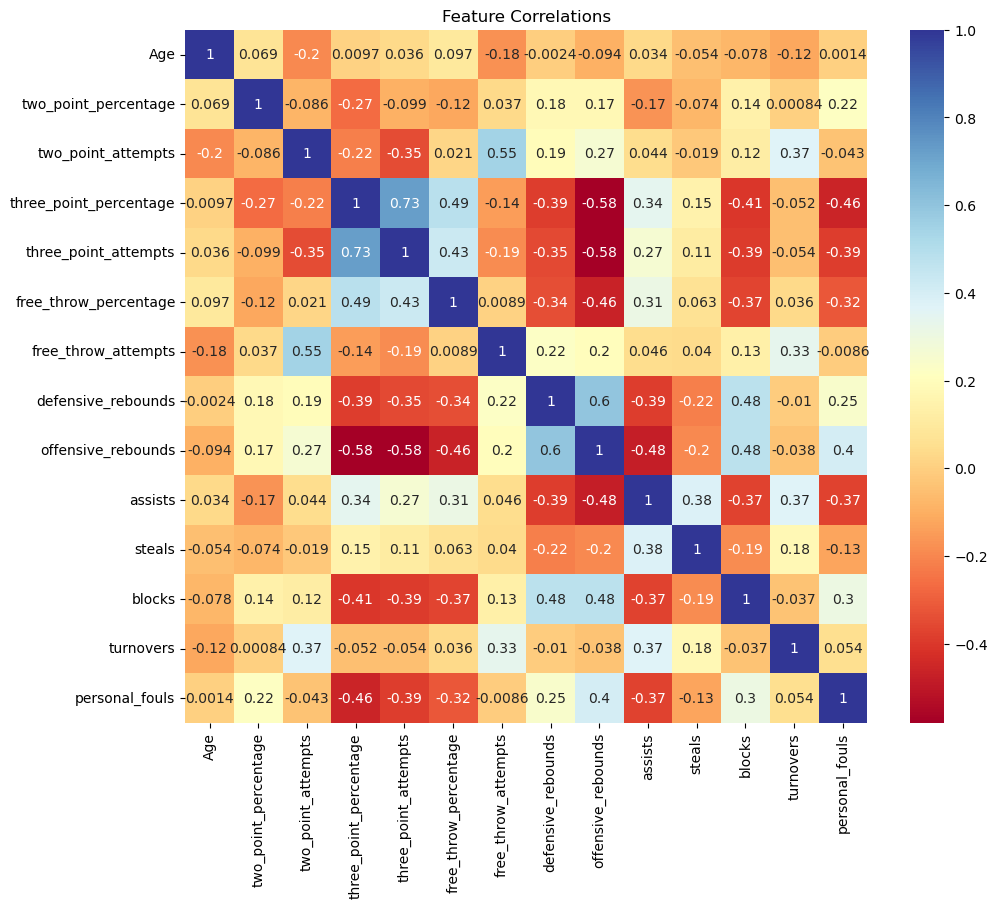

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

cfeatures = ['Age', 'two_point_percentage', 'two_point_attempts', 'three_point_percentage',
              'three_point_attempts', 'free_throw_percentage','free_throw_attempts', 'defensive_rebounds',
              'offensive_rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'personal_fouls']

plt.figure(figsize=(11,9))
plt.title('Feature Correlations')
sns.heatmap(data[cfeatures].corr(), annot = True, cmap = 'RdYlBu');

In [8]:
from collections import defaultdict

# For each feature identify strongly correlated features

corrs = data.corr()
corr_dict = defaultdict(list)

for feature in features:
    feat_corrs = corrs[feature]
    for feat, corr in zip(feat_corrs.index, feat_corrs.values):
        if np.abs(corr) > 0.3 and feat != feature and feat[-2] == 'p':
            corr_dict[feature].append((feat, corr))

for key in corr_dict.keys():
    corr_dict[key] = sorted(corr_dict[key], key=lambda tup: -tup[1])

In [9]:
feat_dict = {}
for feat in list(corr_dict.keys())[1:]:
    feat_dict[feat] = ['two_point_percentage_p1', 'two_point_attempts_p1',
       'three_point_percentage_p1', 'three_point_attempts_p1',
       'free_throw_percentage_p1', 'free_throw_attempts_p1',
       'defensive_rebounds_p1', 'offensive_rebounds_p1', 'assists_p1',
       'steals_p1', 'blocks_p1', 'turnovers_p1', 'personal_fouls_p1']
for key in feat_dict.keys():
    feat_dict[key] = feat_dict[key] + ['Age', 'Age2', 'Age3']
targets = list(feat_dict.keys())

In [10]:
X_train = train[train['season_index'] >= 1][targets]
y_train = train[train['season_index'] >= 1]['two_point_attempts']
X_test = test[test['season_index'] >= 1][targets]
y_test = test[test['season_index'] >= 1]['two_point_attempts']

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [12]:
def evaluate_general_model(model, X_data, y_data, sig = False, mae = True, r2 = False):
    
    preds = model.predict(X_data)
    
    if sig == True:
        preds = sigmoid(preds)
        y_data = sigmoid(y_data)
    
    if mae:
        return mean_absolute_error(y_data, preds)
    
    if r2 == False:
        return mean_squared_error(y_data, preds)
    
    else :
        return r2_score(y_data, preds)

In [13]:
from sklearn.neural_network import MLPRegressor
MLP_model = MLPRegressor(random_state=4, max_iter=500)
MLP_model.fit(X_train, y_train)
evaluate_general_model(MLP_model, X_train, y_train)

0.03412026969970843

In [14]:
preds = MLP_model(X_test)

TypeError: 'MLPRegressor' object is not callable

In [15]:
evaluate_general_model(MLP_model, X_test, y_test)

0.03717248274833784

In [16]:
X_test

,two_point_percentage,two_point_attempts,three_point_percentage,three_point_attempts,free_throw_percentage,free_throw_attempts,defensive_rebounds,offensive_rebounds,assists,steals,blocks,turnovers,personal_fouls
8,-0.080043,10.440835,-0.994623,0.250580,0.455727,4.092807,4.259861,2.589327,2.171694,1.002320,0.584687,2.422274,4.009281
9,-0.200671,9.383795,-0.994623,0.038380,0.485306,4.279318,5.142857,2.974414,1.132196,1.017058,3.051173,1.400853,3.895522
11,-0.116130,11.331046,-0.444791,1.065180,1.496153,5.742710,5.619211,2.963979,2.176672,0.987993,0.957118,1.281304,2.963979
17,-0.036004,12.938992,-0.994623,0.000000,0.676692,4.965517,7.543767,2.435013,1.050398,1.480106,2.291777,3.724138,6.397878
20,-0.160343,12.000000,-0.994623,0.069632,0.562367,4.735010,4.758221,2.947776,1.114120,1.369439,2.321083,1.601547,3.829787
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,-0.376381,13.283654,0.160343,2.596154,0.388826,2.466346,3.677885,0.649038,7.788462,1.557692,0.259615,3.375000,2.163462
10849,-0.096074,8.841747,0.763901,3.879750,1.643422,4.676120,2.348270,0.796370,1.327283,1.082246,0.224617,1.817357,4.226886
10850,-0.152294,13.315600,0.674008,2.950395,1.711263,5.085550,6.159597,2.588066,2.044572,0.828181,0.776420,3.170381,3.338605
10864,-0.164369,9.273341,1.262173,4.211474,1.992430,3.725534,4.535433,0.445444,4.008999,1.660292,0.283465,2.632171,3.199100


In [17]:
y_test

8        10.440835
9         9.383795
11       11.331046
17       12.938992
20       12.000000
           ...    
10836    13.283654
10849     8.841747
10850    13.315600
10864     9.273341
10871    11.820472
Name: two_point_attempts, Length: 2484, dtype: float64

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
grad_model = GradientBoostingRegressor(n_estimators=3)
grad_model.fit(X_train, y_train)
evaluate_general_model(grad_model, X_train, y_train)

1.9848337051014202

In [19]:
evaluate_general_model(grad_model, X_test, y_test)

2.030247633288186

In [20]:
preds = grad_model(X_test)

TypeError: 'GradientBoostingRegressor' object is not callable

In [15]:
class MultiModelContainer:
    
    '''
    Object to function as a container for multiple linear models.
    Initialize with a dictionary where keys are targets and values are lists of features.
    '''
    
    def __init__(self, feature_dict, data):
        
        self.model_dict = {}
        self.feature_dict = feature_dict
        
        # initialize and fit models
        for target in feature_dict.keys():
            features = feature_dict[target]
            self.model_dict[target] = GradientBoostingRegressor(n_estimators=300).fit(data[features], data[target])    

    def predict(self, targets, data, output_df = False, input_df = True, feature_map = None):
        
        switch = False
        
        for target in targets:
            # select features for target
            features = self.feature_dict[target]
            
            if input_df:
                # select model and input data for prediction
                preds = self.model_dict[target].predict(data[features])
            else:
                # if not using a df use feature map to select data from an array
                X = np.hstack(tuple([data[:,feature_map[feature]] for feature in features]))
                preds = self.model_dict[target].predict(X.reshape(-1,len(features)))
            
            if not switch:
                predictions = preds.reshape(-1,1)
                switch = True
                
            else:
                predictions = np.hstack((predictions, preds.reshape(-1,1)))
        
        if not output_df:
            return predictions
        
        else:
            return pd.DataFrame(predictions, columns = targets, index = data.index)

In [16]:
X_train = train[train['season_index'] >= 1]
X_test = test[test['season_index'] >= 1]

In [26]:
MultiModel = MultiModelContainer(feat_dict, X_train)

In [27]:
X_train

,index,Player,train_test,Year,min_age,TOTAL_seasons,season_index,Age,TOTAL_MP,min_proportion,2P%,TOTAL_2PA,3P%,TOTAL_3PA,FT%,TOTAL_FTA,TOTAL_DRB,TOTAL_ORB,TOTAL_AST,TOTAL_STL,TOTAL_BLK,TOTAL_TOV,TOTAL_PF,two_point_attempts,three_point_attempts,free_throw_attempts,defensive_rebounds,offensive_rebounds,assists,steals,blocks,turnovers,personal_fouls,minutes_proportion,two_point_percentage,three_point_percentage,free_throw_percentage,minutes_proportion_p1,two_point_percentage_p1,two_point_attempts_p1,three_point_percentage_p1,three_point_attempts_p1,free_throw_percentage_p1,free_throw_attempts_p1,defensive_rebounds_p1,offensive_rebounds_p1,assists_p1,steals_p1,blocks_p1,turnovers_p1,personal_fouls_p1,Age2,Age3
6,12,A.C. Green,train,1992,27,11,1,28,2902,0.884756,0.495,747,0.3852,56,0.744,457,456,306,117,91,36,111,141,9.266713,0.694693,5.669194,5.656788,3.796003,1.451413,1.128877,0.446589,1.376981,1.749139,2.038261,-0.020001,-0.467534,1.066864,0.662207,0.028002,8.101664,-0.575364,0.914972,1.035599,5.024030,5.240296,3.343808,1.181146,0.981516,0.382625,1.646950,1.946396,784,21952
7,13,Byron Scott,train,1992,29,7,1,30,2679,0.816768,0.479,848,0.6192,157,0.838,291,236,74,226,105,28,119,140,11.395297,2.109742,3.910414,3.171333,0.994401,3.036954,1.410974,0.376260,1.599104,1.881299,1.494604,-0.084049,0.486154,1.643422,1.397767,0.068026,11.388593,0.335924,2.997719,1.367649,2.025856,2.628137,0.739163,2.422814,1.300380,0.287452,1.163498,1.998479,900,27000
10,18,Jack Haley,train,1992,27,7,1,28,394,0.201020,0.369,84,0.2700,0,0.600,29,64,31,7,7,8,25,75,7.675127,0.000000,2.649746,5.847716,2.832487,0.639594,0.639594,0.730964,2.284264,6.852792,-1.379929,-0.536509,-0.994623,0.405465,-0.499900,-0.124159,10.482173,-0.994623,0.000000,0.485306,5.531409,6.601019,4.278438,0.947368,0.611205,0.641766,1.925297,6.081494,784,21952
12,23,Sedale Threatt,train,1992,29,7,1,30,3070,0.935976,0.499,979,0.5814,62,0.831,243,210,43,593,168,16,182,231,11.480130,0.727036,2.849511,2.462541,0.504235,6.953746,1.970033,0.187622,2.134202,2.708795,2.682325,-0.004000,0.328523,1.592731,0.599863,0.116130,13.939981,0.059217,0.609874,1.337023,3.014521,1.289448,0.435624,4.757018,1.969022,0.139400,2.404647,3.328170,900,27000
13,25,Tony Smith,train,1992,22,9,1,23,820,0.325397,0.415,272,0.2160,11,0.653,75,45,31,109,39,8,50,91,11.941463,0.482927,3.292683,1.975610,1.360976,4.785366,1.712195,0.351220,2.195122,3.995122,-0.729079,-0.343333,-1.289131,0.632252,-0.987104,-0.180488,11.033094,-1.289131,0.362590,0.856840,2.952518,2.434532,1.243165,6.992806,1.450360,0.621583,3.574101,4.143885,529,12167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10867,14084,Michael Beasley,train,2017,20,11,8,28,935,0.417411,0.545,363,0.7542,43,0.743,105,153,40,53,27,27,66,92,13.976471,1.655615,4.042781,5.890909,1.540107,2.040642,1.039572,1.039572,2.541176,3.542246,-0.333412,0.180488,1.121139,1.061620,-0.185530,0.124159,19.438017,-0.200671,0.892562,1.242506,4.859504,6.842975,2.876033,1.586777,1.090909,0.892562,2.380165,3.867769,784,21952
10868,14085,Mirza Teletović,train,2017,27,6,4,31,1133,0.404643,0.460,113,0.6138,305,0.778,45,151,11,48,12,13,37,109,3.590468,9.691086,1.429832,4.797882,0.349515,1.525154,0.381289,0.413063,1.175640,3.463372,-0.386157,-0.160343,0.463314,1.254049,0.134379,-0.096074,6.768683,0.882790,9.822064,1.231037,3.309609,5.274021,1.174377,1.900356,0.683274,0.448399,1.793594,3.395018,961,29791
10869,14087,Spencer Hawes,train,2017,19,10,9,28,797,0.368981,0.556,196,0.5562,81,0.846,52,153,38,81,15,30,49,77,8.853199,3.658720,2.348808,6.910916,1.716437,3.658720,0.677541,1.355082,2.213300,3.478043,-0.536589,0.224944,0.225754,1.703567,-0.184734,-0.314569,7.095652,0.714524,3.547826,1.592731,2.260870,6.713043,1.773913,3.791304,0.765217,0.939130,2.017391,3.860870,784,21952
10870,14088,Steve Novak,train,2017,23,11,10,33,22,0.068750,0.750,1,0

NameError: name 'model' is not defined

In [30]:
results = defaultdict(list)

for key in targets:
    
    feats = feat_dict[key]
    
    if key[-10:] == 'percentage':
        
        train_mae = evaluate_general_model(MultiModel.model_dict[key],
                                                X_train[feats], X_train[key], sig = True)
        X_train[feats]
        X_train[key]
        
        test_mae = evaluate_general_model(MultiModel.model_dict[key],
                                                X_test[feats], X_test[key], sig = True)
        train_rmse = np.sqrt(evaluate_general_model(MultiModel.model_dict[key], 
                                                    X_train[feats], X_train[key], sig = True, mae = False))
        test_rmse = np.sqrt(evaluate_general_model(MultiModel.model_dict[key], 
                                           X_test[feats], X_test[key], sig = True, mae = False))
        train_r2 = evaluate_general_model(MultiModel.model_dict[key],
                                                X_train[feats], X_train[key], sig = True, mae = False, r2 = True)
        test_r2 = evaluate_general_model(MultiModel.model_dict[key],
                                                X_test[feats], X_test[key], sig = True, mae = False, r2 = True)
        stddev = sigmoid(data[key]).std()
        
        results['train_mae'].append(np.round(train_mae, 3))
        results['train_zscore'].append(np.round(train_mae/stddev, 3))
        results['train_RMSE'].append(np.round(train_rmse, 3))
        results['train_R^2'].append(np.round(train_r2, 3))
        results['test_mae'].append(np.round(test_mae, 3))
        results['test_zscore'].append(np.round(test_mae/stddev, 3))
        results['test_RMSE'].append(np.round(test_rmse, 3))
        results['test_R^2'].append(np.round(test_r2, 3))
        
    else:
        train_mae = evaluate_general_model(MultiModel.model_dict[key], X_train[feats], X_train[key])
        test_mae = evaluate_general_model(MultiModel.model_dict[key], X_test[feats], X_test[key])
        train_rmse = np.sqrt(evaluate_general_model(MultiModel.model_dict[key], X_train[feats], X_train[key], mae = False))
        test_rmse = np.sqrt(evaluate_general_model(MultiModel.model_dict[key], X_test[feats], X_test[key], mae = False))
        train_r2 = evaluate_general_model(MultiModel.model_dict[key], X_train[feats], X_train[key], mae = False, r2 = True)
        test_r2 = evaluate_general_model(MultiModel.model_dict[key], X_test[feats], X_test[key], mae = False, r2 = True)
        stddev = data[key].std()
        
        results['train_mae'].append(np., sig = True, mae = False, r2 = True(train_mae, 3))
        results['train_zscore'].append(np.round(train_mae/stddev, 3))
        results['train_RMSE'].append(np.round(train_rmse, 3))
        results['train_R^2'].append(np.round(train_r2, 3))
        results['test_mae'].append(np.round(test_mae, 3))
        results['test_zscore'].append(np.round(test_mae/stddev, 3))
        results['test_RMSE'].append(np.round(test_rmse, 3))
        results['test_R^2'].append(np.round(test_r2, 3))

results = pd.DataFrame(results, index = feat_dict.keys())

In [19]:
results

,train_mae,train_zscore,train_RMSE,train_R^2,test_mae,test_zscore,test_RMSE,test_R^2
two_point_percentage,0.043,0.522,0.062,0.450,0.052,0.625,0.076,0.107
two_point_attempts,1.234,0.361,1.637,0.773,1.379,0.403,1.826,0.718
three_point_percentage,0.065,0.350,0.094,0.749,0.077,0.414,0.112,0.636
three_point_attempts,0.587,0.234,0.875,0.874,0.717,0.285,1.239,0.793
free_throw_percentage,0.042,0.465,0.055,0.640,0.048,0.528,0.063,0.504
free_throw_attempts,0.721,0.379,0.985,0.720,0.859,0.451,1.203,0.589
defensive_rebounds,0.620,0.310,0.863,0.804,0.721,0.360,1.111,0.723
offensive_rebounds,0.345,0.253,0.501,0.867,0.417,0.306,0.704,0.718
assists,0.555,0.262,0.768,0.870,0.625,0.295,0.929,0.801
steals,0.232,0.423,0.329,0.634,0.279,0.508,0.419,0.365


In [20]:
results.sum()[['train_zscore', 'test_zscore']]

train_zscore    4.528
test_zscore     5.334
dtype: float64